In [1]:
import osmnx as ox
import geopandas as gpd
import os

# 画图
import geopandas as gpd
import matplotlib.pyplot as plt

import json
from shapely.geometry import shape

In [2]:
roads=gpd.read_file("../data/export.geojson")
print(roads.columns.tolist())

['id', '@id', 'access', 'alt_name', 'bicycle', 'bridge', 'bus', 'busway:opening_hours', 'busway:right', 'button_operated', 'covered', 'crossing', 'crossing:island', 'crossing:markings', 'crossing:signals', 'crossing_ref', 'cycle_network', 'cyclestreets_id', 'cycleway', 'cycleway:left', 'cycleway:right', 'cycleway:right:oneway', 'cycleway:surface', 'description', 'disused:cycleway:left', 'dual_carriageway', 'emergency', 'est_width', 'fixme:by', 'foot', 'footway', 'footway:surface', 'highway', 'horse', 'image', 'incorrect_name', 'is_sidepath', 'lane_markings', 'lanes', 'lanes:backward', 'lanes:bus:forward:conditional', 'lanes:forward', 'layer', 'lit', 'mapillary', 'maxheight', 'maxspeed', 'maxweight', 'motor_vehicle', 'motor_vehicle:conditional', 'motor_vehicle:electric', 'motorcycle', 'name', 'name:etymology:wikidata', 'name:ja', 'name:zh', 'name:zh-Hans', 'name:zh-Hant', 'not:name', 'note', 'note:covid19', 'old_name', 'old_ref', 'oneway', 'oneway:bicycle', 'oneway:foot', 'operator', 'o

In [3]:
def classify_bike_facility(row):
    highway = row.get("highway")
    cycleway = row.get("cycleway")
    cycleway_left = row.get("cycleway:left")
    cycleway_right = row.get("cycleway:right")
    segregated = str(row.get("segregated")).lower() if row.get("segregated") else ""
    bicycle = str(row.get("bicycle")).lower() if row.get("bicycle") else ""

    # 1. 专用骑行路
    if isinstance(highway, list):
        if "cycleway" in highway:
            return "dedicated"
    elif highway == "cycleway":
        return "dedicated"

    # 2. 有物理隔离（cycle track）
    if (cycleway in ["track"]) or (segregated in ["yes", "true"]):
        return "protected"

    # 3. 有划线车道但无隔离
    if cycleway in ["lane", "opposite", "shared_lane"]:
        return "paint_only"
    if cycleway_left or cycleway_right:
        return "paint_only"

    # 4. 虽无设施但允许骑行
    if bicycle in ["yes", "designated"]:
        return "shared"

    # 5. 其他（无骑行设施）
    return "none"

# 应用分类函数
roads["bike_facility_type"] = roads.apply(classify_bike_facility, axis=1)

bike_facility_type
dedicated     0.475564
paint_only    0.357143
none          0.150376
shared        0.015038
protected     0.001880
Name: proportion, dtype: float64


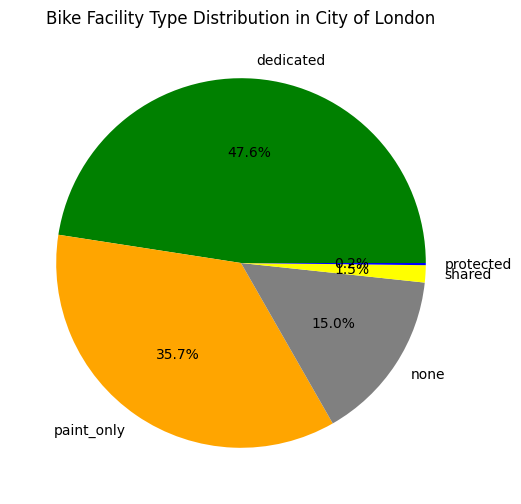

In [5]:
print(roads["bike_facility_type"].value_counts(normalize=True))

counts = roads["bike_facility_type"].value_counts()
colors = {"dedicated": "green", "protected": "blue", "paint_only": "orange", "shared": "yellow", "none": "grey"}

counts.plot.pie(autopct='%1.1f%%', colors=[colors[k] for k in counts.index], figsize=(6, 6), ylabel="", title="Bike Facility Type Distribution in City of London")
plt.show()


In [6]:
# === 3. 清洗字段 maxspeed / lanes ===
def parse_speed(s):
    if s is None:
        return None
    try:
        return int(str(s).split()[0])
    except:
        return None

def parse_lanes(l):
    if isinstance(l, list):
        try:
            return int(l[0])
        except:
            return None
    try:
        return int(l)
    except:
        return None

roads["maxspeed"] = roads["maxspeed"].apply(parse_speed)
roads["lanes"] = roads["lanes"].apply(parse_lanes)

# === 4. LTS 估算函数（基于设施类型 + 限速 + 车道数）===
DEFAULT_SPEED = {
    "residential": 25, "tertiary": 30, "secondary": 35, "primary": 40, "trunk": 45
}
DEFAULT_LANES = {
    "residential": 2, "tertiary": 2, "secondary": 3, "primary": 4, "trunk": 4
}

def estimate_lts(functional_class, facility_type, speed_limit, lane_count):
    if isinstance(functional_class, list):
        functional_class = functional_class[0]

    speed_limit = speed_limit or DEFAULT_SPEED.get(functional_class, 35)
    lane_count = lane_count or DEFAULT_LANES.get(functional_class, 3)

    if facility_type == "dedicated":
        return 1
    if facility_type == "protected":
        if speed_limit <= 30 and lane_count <= 2:
            return 2
        return 3
    if facility_type == "paint_only":
        if speed_limit <= 30 and lane_count <= 2:
            return 3
        return 4
    if facility_type == "shared":
        if speed_limit <= 25 and lane_count <= 1:
            return 3
        return 4
    if facility_type == "none":
        if functional_class in ["residential", "living_street"] and speed_limit <= 25:
            return 3
        return 4

    return 4

roads["lts"] = roads.apply(lambda row: estimate_lts(
    row.get("highway"),
    row.get("bike_facility_type"),
    row.get("maxspeed"),
    row.get("lanes")
), axis=1)

# === 5. 输出分布统计表（LTS 分类数量）===
print(roads["lts"].value_counts().sort_index())

lts
1    253
2      1
3     64
4    214
Name: count, dtype: int64


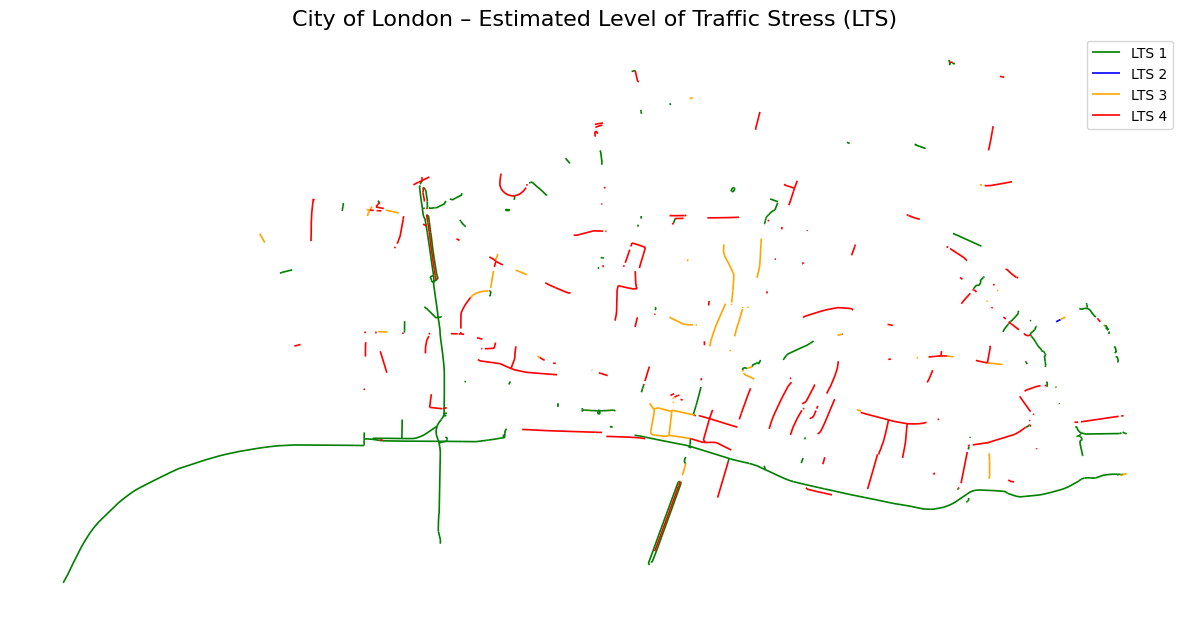

In [7]:
import matplotlib.pyplot as plt

# 设置颜色映射
color_map = {
    1: "green",
    2: "blue",
    3: "orange",
    4: "red"
}

# 将颜色列添加进去
roads["color"] = roads["lts"].map(color_map)

# 绘图
fig, ax = plt.subplots(figsize=(12, 12))

for level in sorted(roads["lts"].dropna().unique()):
    roads[roads["lts"] == level].plot(
        ax=ax,
        color=color_map[level],
        linewidth=1.2,
        label=f"LTS {level}"
    )

ax.set_title("City of London – Estimated Level of Traffic Stress (LTS)", fontsize=16)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28288\563287468.py:119: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


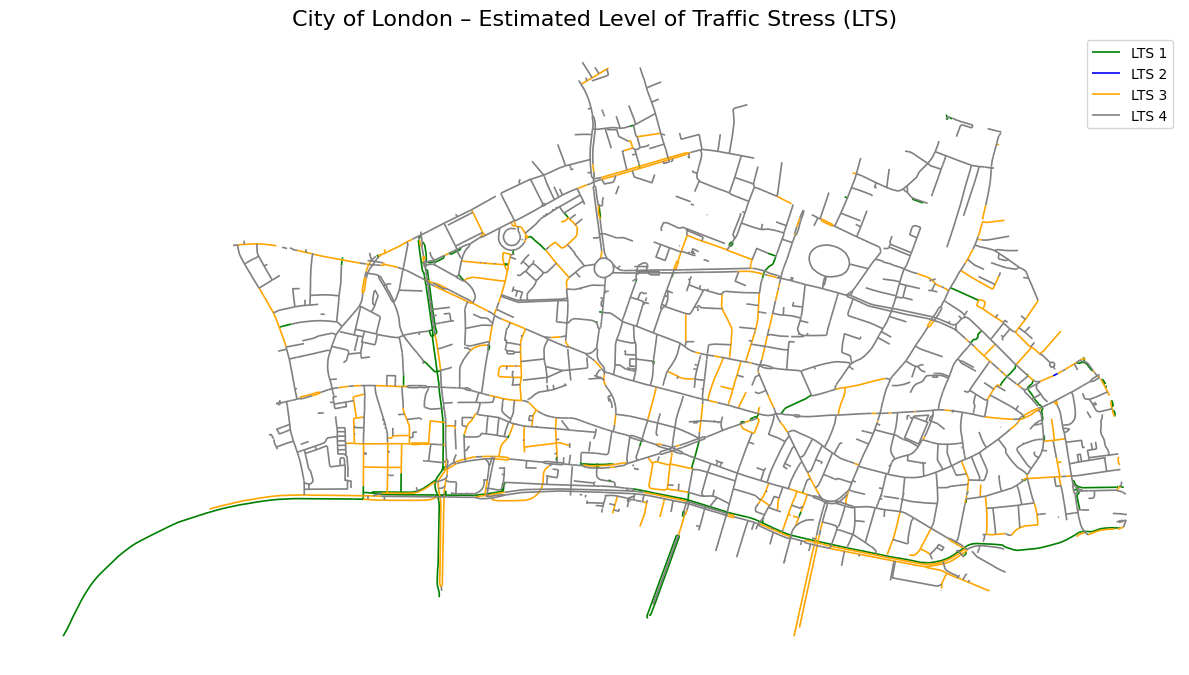

In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 读取你的 GeoJSON 文件 ===
roads = gpd.read_file("../data/kegongqixing.geojson")  # 修改为你真实路径

# === 2. 自动分类 bike_facility_type ===
def classify_bike_facility(row):
    highway = row.get("highway")
    cycleway = row.get("cycleway")
    cycleway_left = row.get("cycleway:left")
    cycleway_right = row.get("cycleway:right")
    segregated = str(row.get("segregated")).lower() if row.get("segregated") else ""
    bicycle = str(row.get("bicycle")).lower() if row.get("bicycle") else ""

    if isinstance(highway, list):
        if "cycleway" in highway:
            return "dedicated"
    elif highway == "cycleway":
        return "dedicated"

    if cycleway in ["track"] or segregated in ["yes", "true"]:
        return "protected"

    if cycleway in ["lane", "opposite", "shared_lane"]:
        return "paint_only"
    if cycleway_left or cycleway_right:
        return "paint_only"

    if bicycle in ["yes", "designated"]:
        return "shared"

    return "none"

roads["bike_facility_type"] = roads.apply(classify_bike_facility, axis=1)

# === 3. 清洗速度和车道数字段 ===
def parse_speed(s):
    if s is None:
        return None
    try:
        return int(str(s).split()[0])
    except:
        return None

def parse_lanes(l):
    if isinstance(l, list):
        try:
            return int(l[0])
        except:
            return None
    try:
        return int(l)
    except:
        return None

roads["maxspeed"] = roads["maxspeed"].apply(parse_speed)
roads["lanes"] = roads["lanes"].apply(parse_lanes)

# === 4. LTS 估算函数（逻辑来自 Conveyal 框架）===
DEFAULT_SPEED = {
    "residential": 25, "tertiary": 30, "secondary": 35, "primary": 40, "trunk": 45
}
DEFAULT_LANES = {
    "residential": 2, "tertiary": 2, "secondary": 3, "primary": 4, "trunk": 4
}

def estimate_lts(functional_class, facility_type, speed_limit, lane_count):
    if isinstance(functional_class, list):
        functional_class = functional_class[0]

    speed_limit = speed_limit or DEFAULT_SPEED.get(functional_class, 35)
    lane_count = lane_count or DEFAULT_LANES.get(functional_class, 3)

    if facility_type == "dedicated":
        return 1
    if facility_type == "protected":
        if speed_limit <= 30 and lane_count <= 2:
            return 2
        return 3
    if facility_type == "paint_only":
        if speed_limit <= 30 and lane_count <= 2:
            return 3
        return 4
    if facility_type == "shared":
        if speed_limit <= 25 and lane_count <= 1:
            return 3
        return 4
    if facility_type == "none":
        if functional_class in ["residential", "living_street"] and speed_limit <= 25:
            return 3
        return 4

    return 4

roads["lts"] = roads.apply(lambda row: estimate_lts(
    row.get("highway"),
    row.get("bike_facility_type"),
    row.get("maxspeed"),
    row.get("lanes")
), axis=1)

# === 5. 可视化：绘制 LTS 等级地图 ===
color_map = {
    1: "green",
    2: "blue",
    3: "orange",
    4: "grey"
}
roads["color"] = roads["lts"].map(color_map)

fig, ax = plt.subplots(figsize=(12, 12))
for level in sorted(roads["lts"].dropna().unique()):
    roads[roads["lts"] == level].plot(ax=ax, color=color_map[level], linewidth=1.2, label=f"LTS {level}")

ax.set_title("City of London – Estimated Level of Traffic Stress (LTS)", fontsize=16)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()
